In [10]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [11]:
import numpy as np
import scipy.optimize as opt
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.providers.fake_provider import FakeAthens
import mthree

In [12]:
H_op = [(0.39793742484318045, 'YZ'), (-0.39793742484318045, 'ZI'),
       (-0.01128010425623538, 'ZZ'), (0.18093119978423156, 'XX')]

In [13]:
ansatz = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cx')

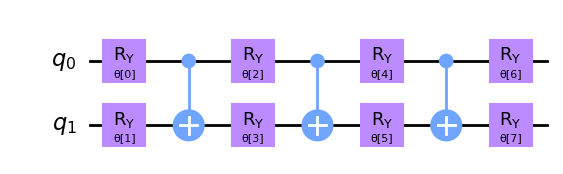

In [14]:
ansatz.decompose().draw('mpl')

In [15]:
coeffs = np.array([item[0] for item in H_op], dtype=float)
op_strings = [item[1] for item in H_op]

In [16]:
def opstr_to_meas_circ(op_str):
    num_qubits = len(op_str[0])
    circs = []
    for op in op_str:
        qc = QuantumCircuit(num_qubits)
        for idx, item in enumerate(op):
            if item == 'X':
                qc.h(num_qubits-idx-1)
            elif item == 'Y':
                qc.sdg(num_qubits-idx-1)
                qc.h(num_qubits-idx-1)
        circs.append(qc)
    return circs

In [17]:
meas_circs = opstr_to_meas_circ(op_strings)

In [18]:
full_circs = [ansatz.compose(meas_circs[kk]).measure_all(inplace=False) for kk in range(len(meas_circs))]

In [19]:
meas_strings = [string.replace('X', 'Z').replace('Y', 'Z') for string in op_strings]
meas_strings

['ZZ', 'ZI', 'ZZ', 'ZZ']

In [20]:
backend = FakeAthens()
trans_circs = transpile(full_circs, backend)

In [21]:
len(trans_circs)

4

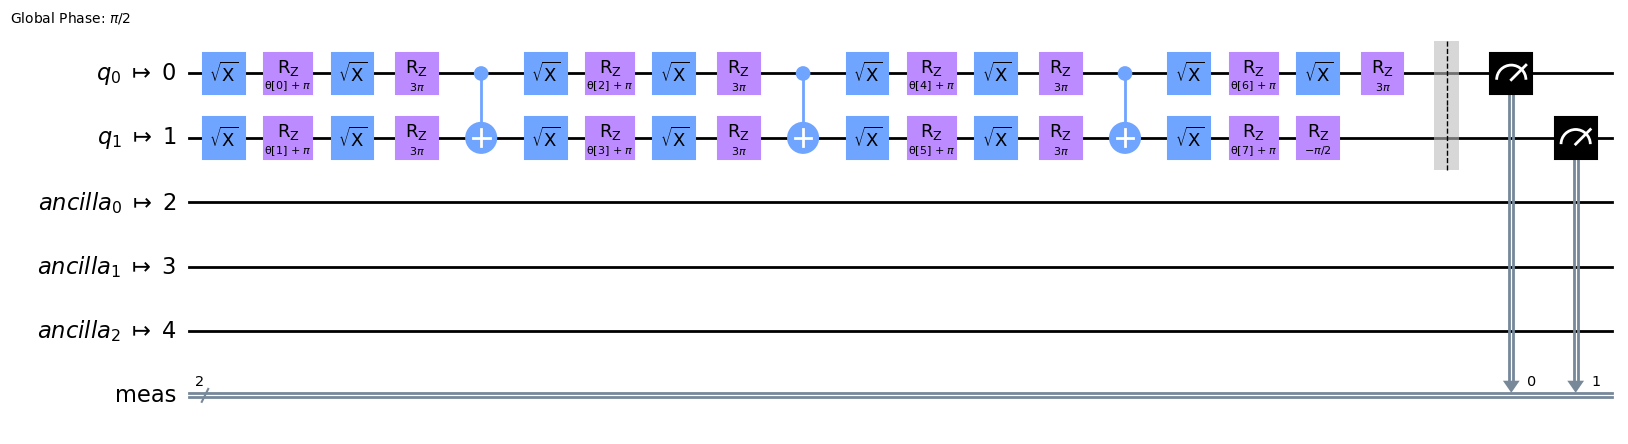

In [22]:
trans_circs[0].draw('mpl')

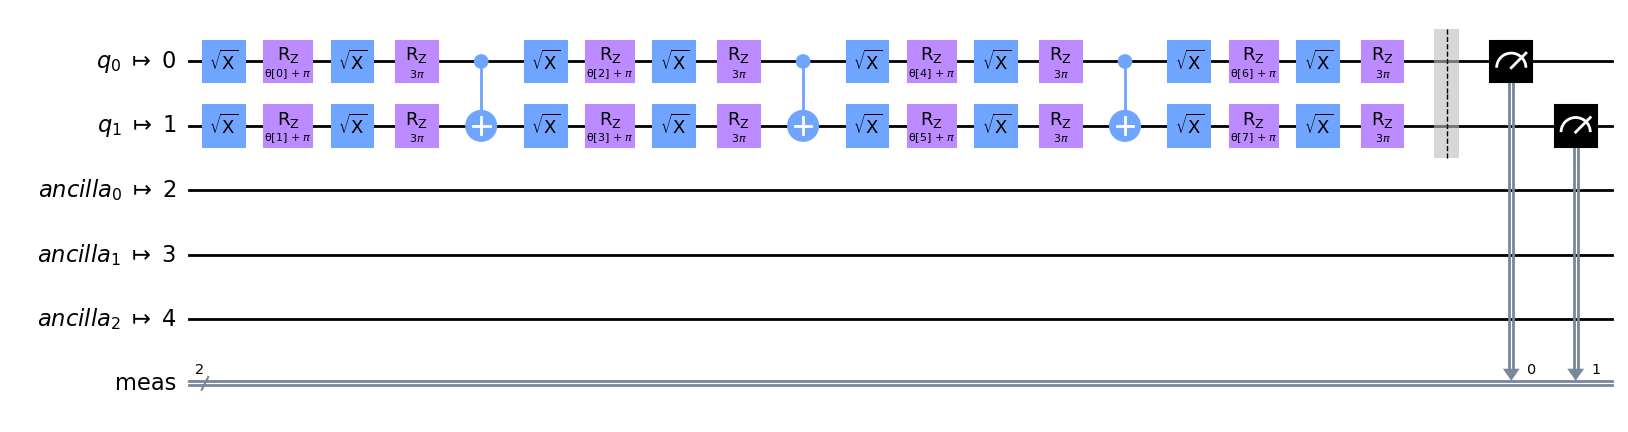

In [23]:
trans_circs[1].draw('mpl')

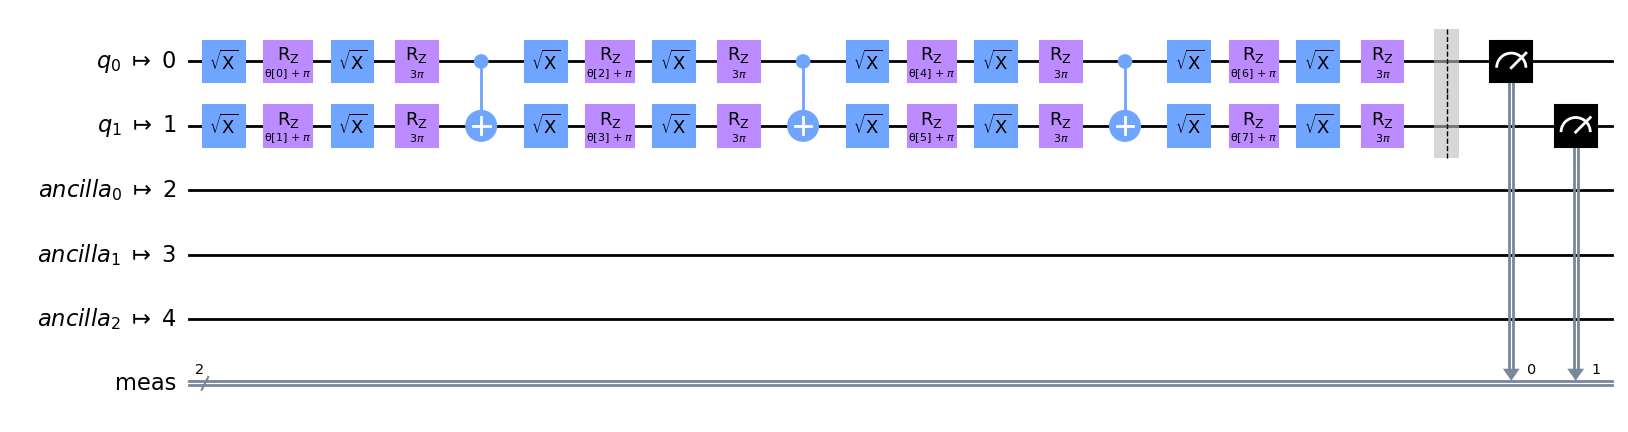

In [24]:
trans_circs[2].draw('mpl')

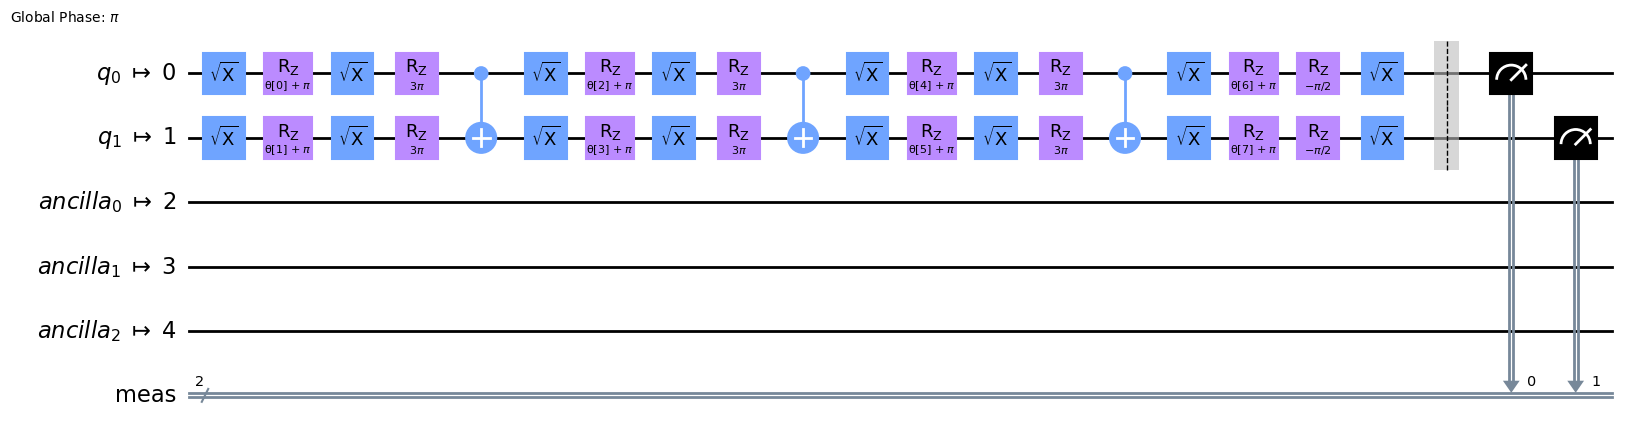

In [25]:
trans_circs[3].draw('mpl')

In [26]:
num_params = ansatz.num_parameters
params = np.array([1.22253725, 0.39053752, 0.21462153, 5.48308027,
                   2.06984514, 3.65227416, 4.01911194, 0.35749589])
params += 0.05*(np.random.random(params.shape[0])-0.5)

In [27]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system([0,1])

In [28]:
def vqe_func(params, *args):
    # Attach parameters to the transpiled circuit variables
    bound_circs = [circ.bind_parameters(params) for circ in trans_circs]
    # Submit the job and get the resultant counts back
    counts = backend.run(bound_circs, shots=4096).result().get_counts()
    # Apply mitigation to get quasi-probabilities
    quasis = mit.apply_correction(counts, [0,1])
    # Evaluate the coefficients times each expectation value obtained from quasi-probabilities and sum.
    energy = np.sum(coeffs*quasis.expval(meas_strings))
    return energy

In [29]:
res = opt.minimize(vqe_func, params, method = 'COBYLA')

In [30]:
print(res.fun)
print(np.mod(res.x, 2*np.pi))

-0.4236737054586174
[1.21948165 0.4330656  0.08548072 5.60340076 2.04512098 3.67035065
 4.04183428 0.34592456]
